## Import libraries

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from fbprophet import Prophet
warnings.filterwarnings('ignore')

## Functions

In [206]:
def test_stationarity(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def calc_hour_quarter(dt):
    if round((float(dt.minute) + float(dt.second)/60) / 15) == 0:
        return 1
    return round((float(dt.minute) + float(dt.second)/60) / 15)
def hour_regressor(ds):
    date = pd.to_datetime(ds)
    if (date.hour < 4 or date.hour > 21) :
        return 1
    else:
        return 0
def weekday_regressor(ds):
    date = pd.to_datetime(ds)
    if (date.weekday() < 5 or date.weekday() > 2) :
        return 1
    else:
        return 0
def density_regressor(density):
    if density < 7 :
        return 1
    else:
        return 0
def speed_regressor(speed):
    if speed > 70 :
        return 1
    else:
        return 0
def filter_hours(ds, h1, h2):
    ds = pd.to_datetime(ds)
    if (ds.hour > h1 or ds.hour < h2):
        return 1
    else: 
        return 0
def speed_shifted(speed):
    return 1 if speed > 70 else 0

## Import data and add features

In [219]:
df = pd.read_csv('dataset.csv')
df = df.set_index(pd.to_datetime(df.date), inplace=False)
df = df.rename(columns={'date':'ds', 'label':'y'})

df['speed_morning'] = 0
df['speed_morning'][(df.Hour > 1) & (df.Hour < 4)] = 1

df['specialTime_regressor'] = 0
df['specialTime_regressor']['2019-02-04'][(df.Hour > 11) & (df.Hour < 15)] = 1
df['specialTime_regressor']['2019-02-05'][(df.Hour > 11) & (df.Hour < 15)] = 1
df['specialTime_regressor']['2019-02-03'][(df.Hour > 10) & (df.Hour < 12)] = 1
df['saturday_regressor'] = 0
df['saturday_regressor'][(df.DOW == 5) & (df.Hour > 11) & (df.Hour < 14)] = 1
df['holiday_regressor'] = 0
df['holiday_regressor']['2019-02-09'][(df.Hour > 5) & (df.Hour < 20)] = 1 
df['holiday_regressor']['2019-02-10'][(df.Hour > 5) & (df.Hour < 20)] = 1
df['holiday_regressor']['2019-02-11'][(df.Hour > 5) & (df.Hour < 20)] = 1

holidays = df.copy()
holidays['holiday'] = '0'
holidays['holiday']['2019-02-09'] = 'playoff'
holidays['holiday']['2019-02-10'] = 'playoff'
holidays['holiday']['2019-02-11'] = 'playoff'
holidays = holidays.drop(columns=['DOW', 'Hour', 'density', 'speed', 'y'])
holidays = holidays[holidays.holiday != '0']

t = df[df.y != -1]
end_Index_train = int(len(t)*0.9)
train = t[:end_Index_train]
test = t[end_Index_train:]

## Hour of Day 75% quantile speed 

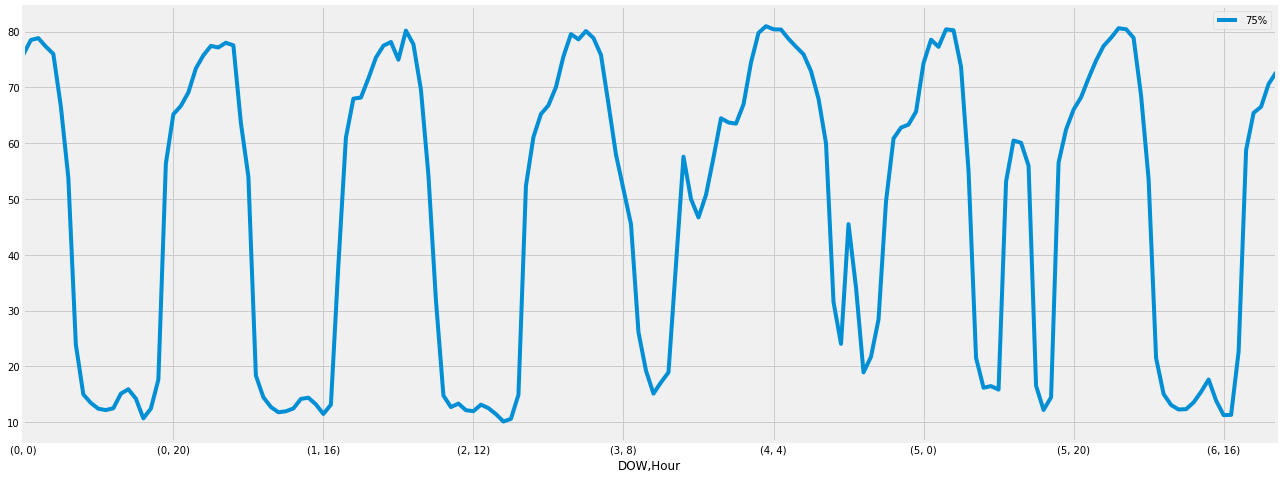

In [171]:
#shits
x = df.groupby(['DOW', 'Hour']).y.describe()
x[['75%']].plot(figsize=(20,8))

## Thursday, Friday ,Saturday special speed behavior 

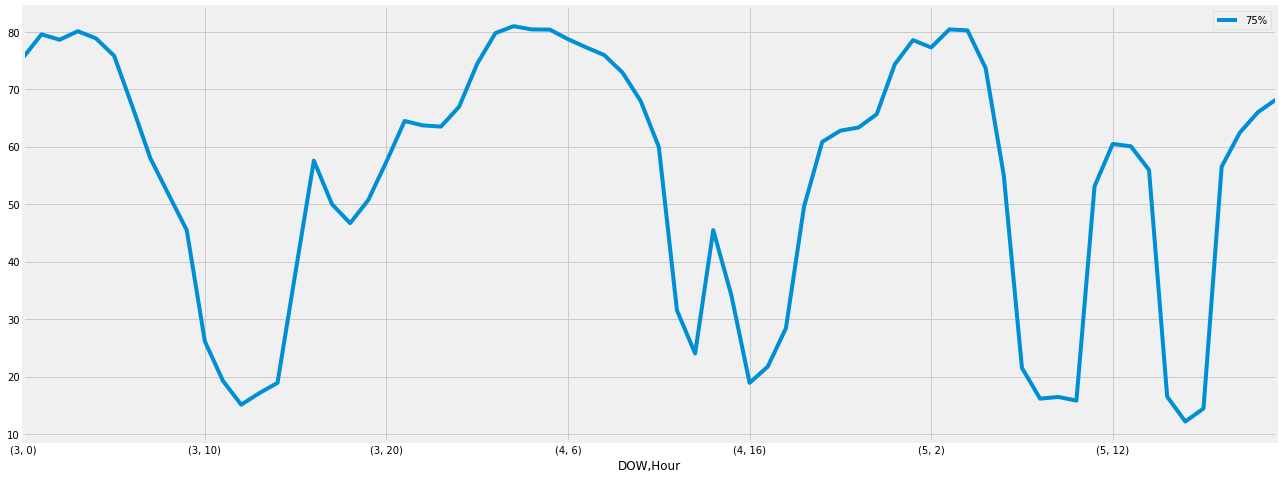

In [26]:
x[['75%']].iloc[72:142].plot(figsize=(20,8))

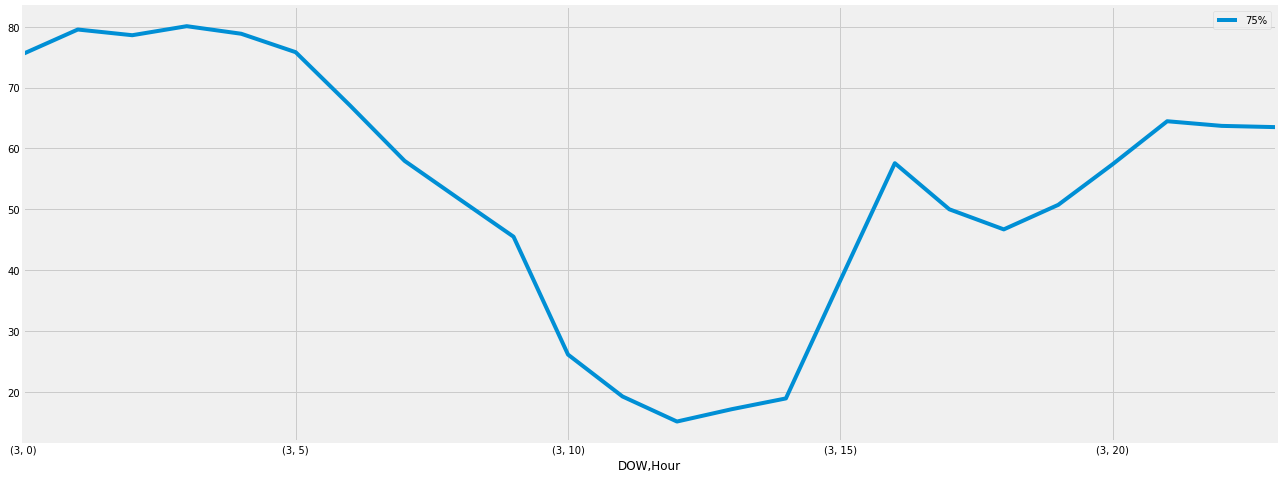

In [46]:
x[['75%']].iloc[72:96].plot(figsize=(20,8))

## Hour of Day mean speed 

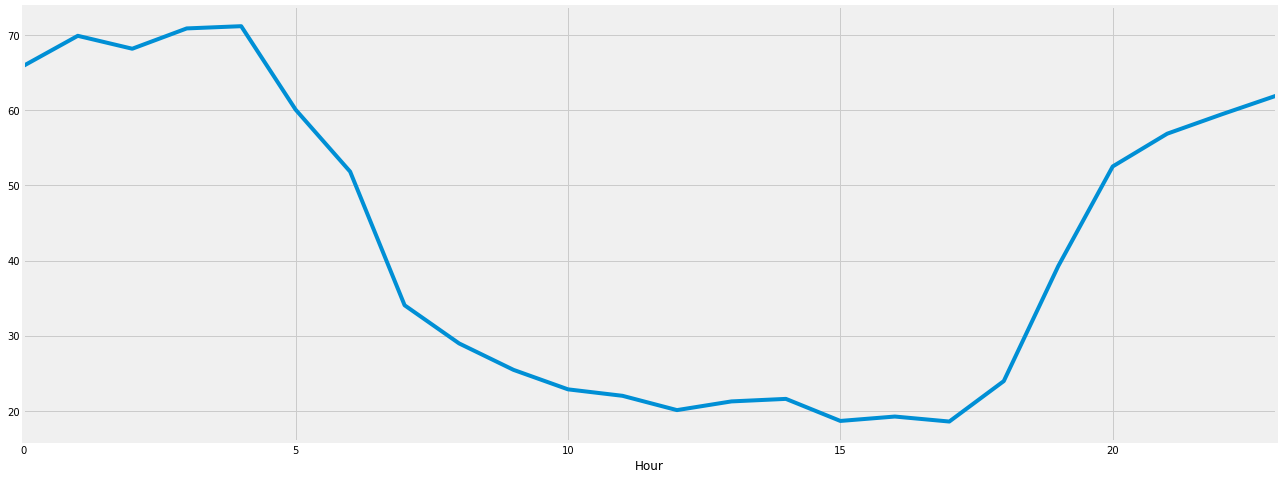

In [35]:
x = df.groupby(['Hour']).y.describe()
x['mean'].plot(figsize=(20,8))

## Look at data

#### time series isn't stationarity.(p-value > 0.05)

Results of Dickey-Fuller Test:
Test Statistic                -1.581549e+01
p-value                        1.034733e-28
#Lags Used                     3.200000e+01
Number of Observations Used    4.735000e+03
Critical Value (1%)           -3.431732e+00
Critical Value (5%)           -2.862151e+00
Critical Value (10%)          -2.567095e+00
dtype: float64


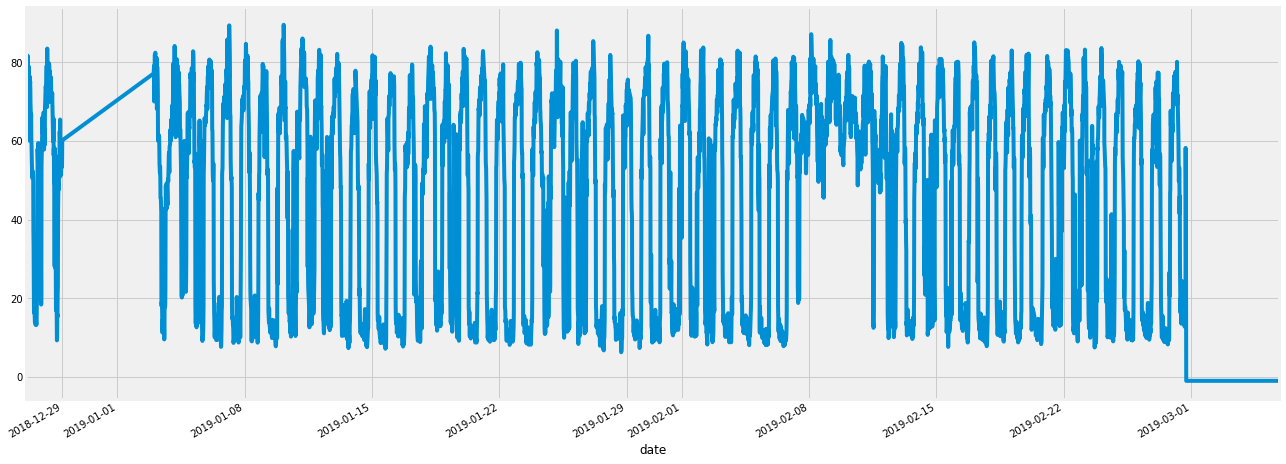

In [93]:
df.y.plot(figsize=(20,8))
test_stationarity(train.y)

## Investigate in special days

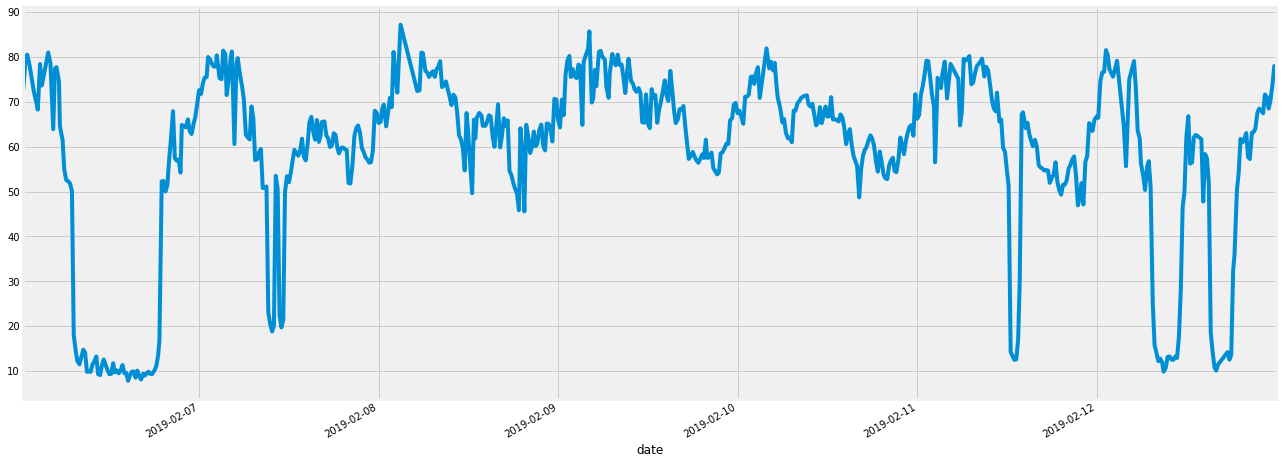

In [34]:
df['2019-02-06':'2019-02-12'].y.plot(figsize=(20,8))

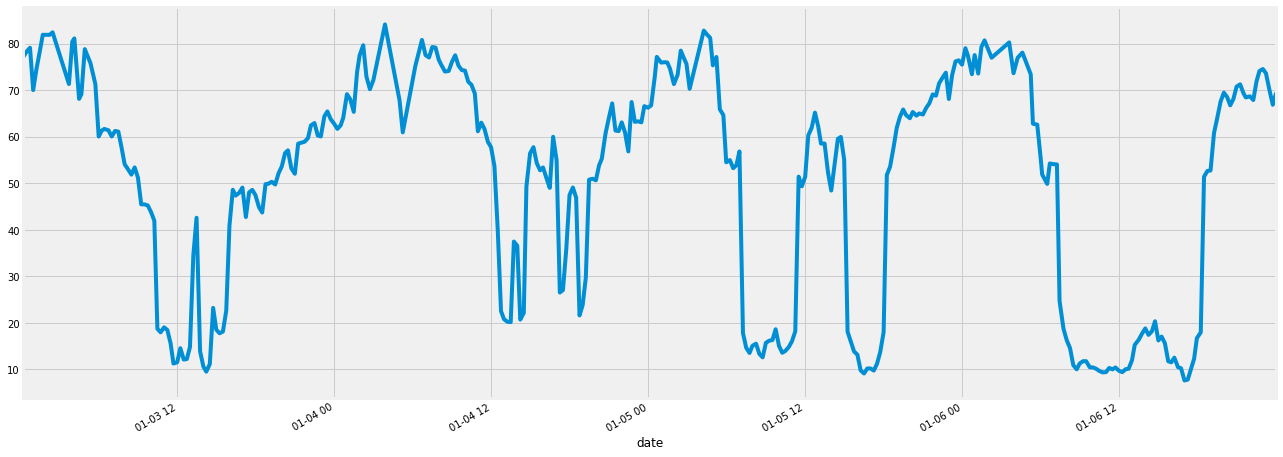

In [41]:
df['2019-01-01':'2019-01-6'].y.plot(figsize=(20,8))

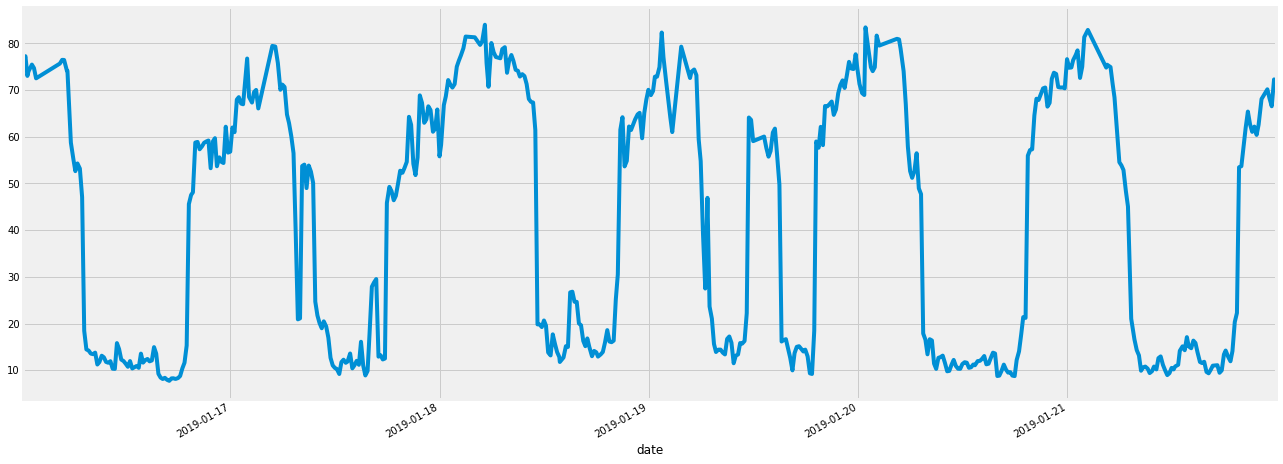

In [39]:
df['2019-01-16':'2019-01-21'].y.plot(figsize=(20,8))

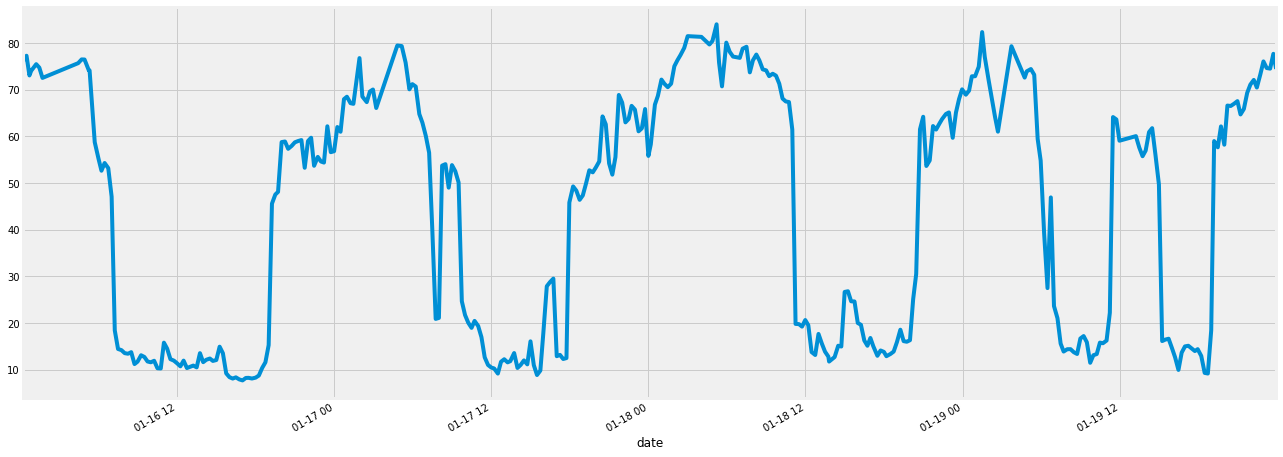

In [43]:
df['2019-01-16':'2019-01-19'].y.plot(figsize=(20,8))

## Fit prophet and predict

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


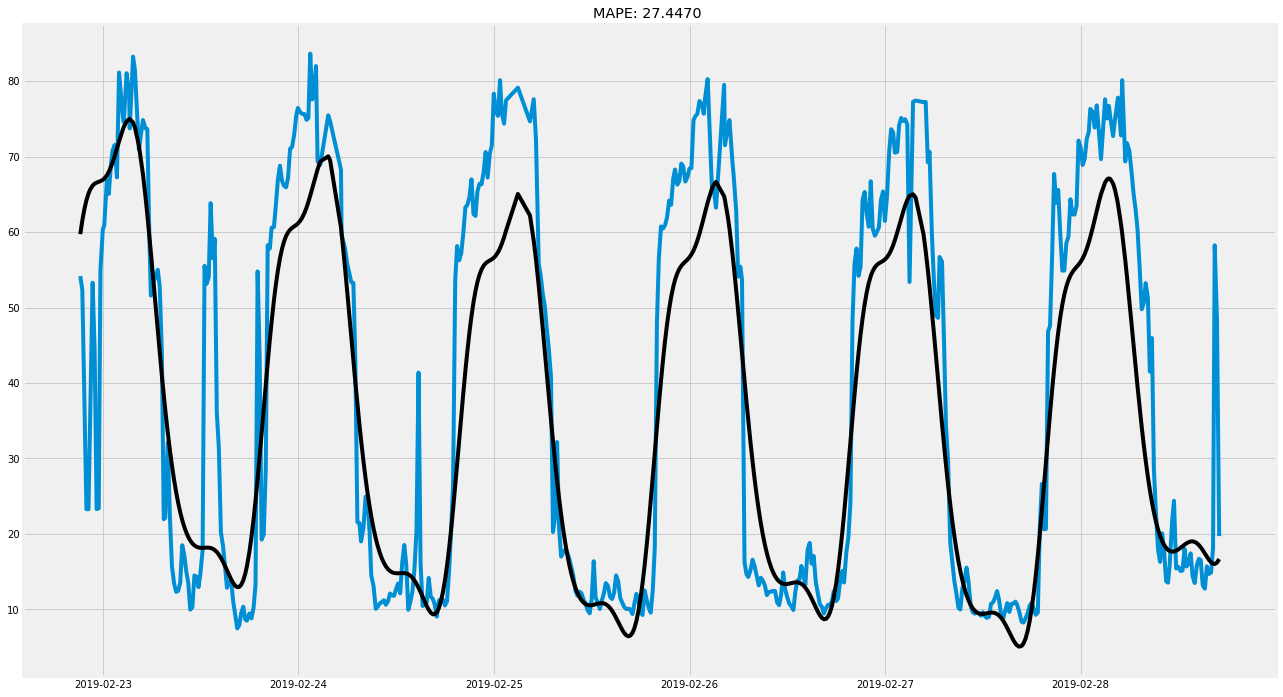

In [145]:
m = Prophet(holidays=holidays, holidays_prior_scale=0.045).fit(train)
forecast = m.predict(test)
forecast['y'] = test.y.values
forecast = forecast.set_index('ds')
plt.figure(figsize=(20, 12))
plt.plot(forecast.y)
plt.plot(forecast.yhat, color='k')
plt.title('MAPE: %.4f '% mean_absolute_percentage_error(forecast.y, forecast.yhat))
plt.show()

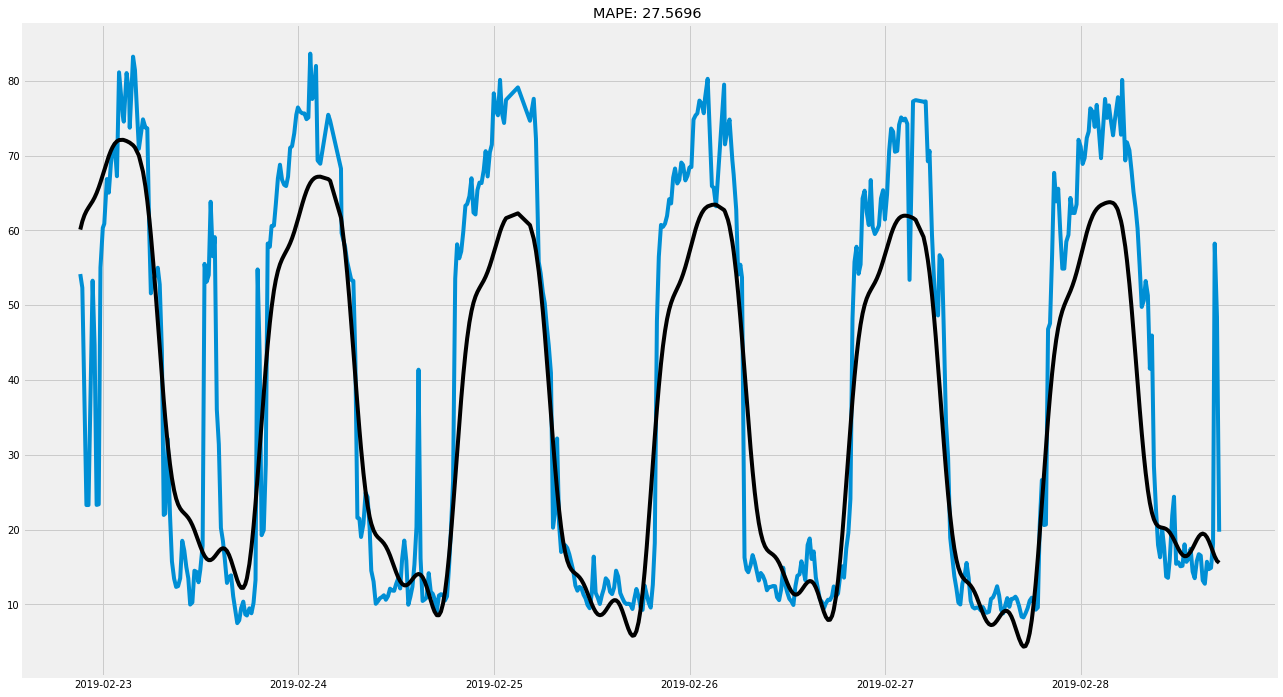

In [209]:
m = Prophet(holidays=holidays, holidays_prior_scale=0.045, yearly_seasonality=False)
m.add_seasonality(name='Hourly',period=1,fourier_order=5, prior_scale=0.06)

m.fit(train)
forecast = m.predict(test)
forecast['y'] = test.y.values
forecast = forecast.set_index('ds')
plt.figure(figsize=(20, 12))
plt.plot(forecast.y)
plt.plot(forecast.yhat, color='k')
plt.title('MAPE: %.4f '% mean_absolute_percentage_error(forecast.y, forecast.yhat))
plt.show()

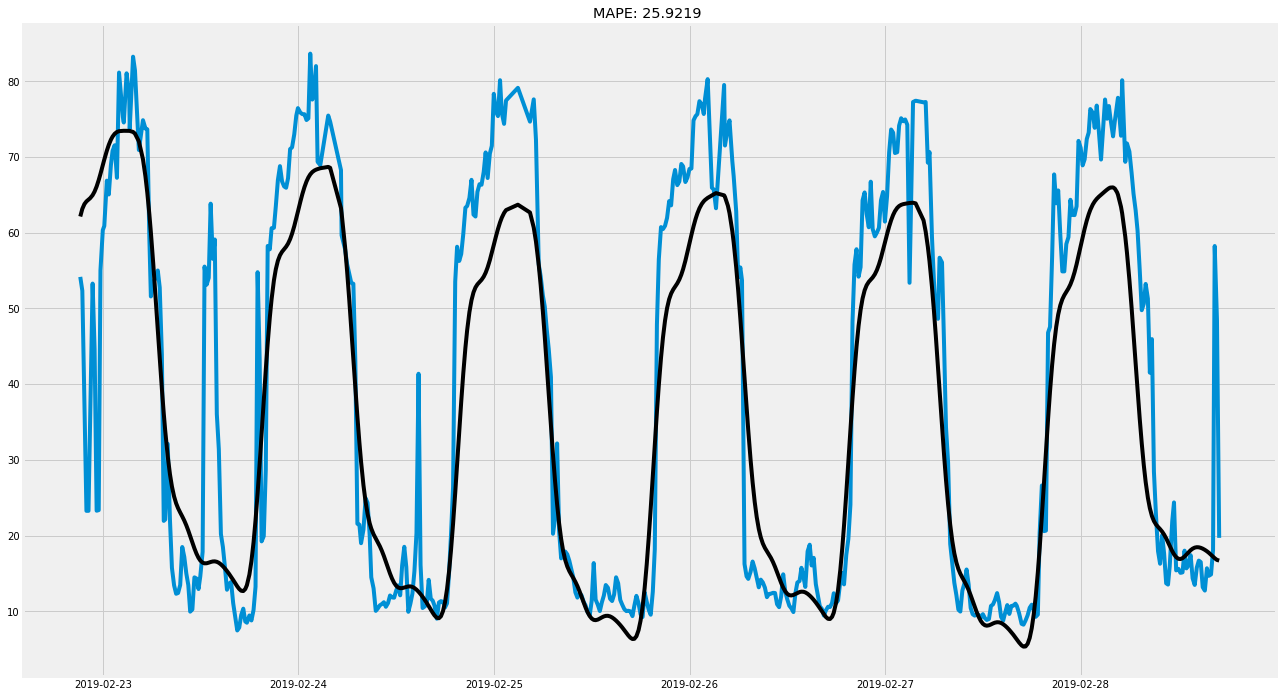

In [228]:
m = Prophet(holidays=holidays, holidays_prior_scale=0.045, yearly_seasonality=False)
m.add_seasonality(name='Hourly',period=1,fourier_order=7, prior_scale=0.01)
m.add_regressor('holiday_regressor')

m.fit(train)
forecast = m.predict(test)
forecast['y'] = test.y.values
forecast = forecast.set_index('ds')
plt.figure(figsize=(20, 12))
plt.plot(forecast.y)
plt.plot(forecast.yhat, color='k')
plt.title('MAPE: %.4f '% mean_absolute_percentage_error(forecast.y, forecast.yhat))
plt.show()

# SARIMA

In [261]:
#Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=31911.092, BIC=31943.427, Fit time=42.957 seconds
model = sm.tsa.statespace.SARIMAX(train.y, order=(0, 1, 2), seasonal_order=(0, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

start = test.index.min()
end = test.index.max()

forecast = results.predict(start='2019-02-22 20:59:24.838000', end='2019-02-28', freq='15T', dynamic=False)
plt.figure(figsize=(20, 12))
plt.plot(forecast)
plt.plot(test.y, color='k')
plt.title('MAPE: %.4f '% mean_absolute_percentage_error(test.y, forecast))
plt.show()

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [260]:
print(start)
print(end)
print(train.index.max())

2019-02-22 21:14:02.632000
2019-02-28 16:59:48.329000
2019-02-22 20:59:24.838000


In [256]:
test

,ds,DOW,Hour,density,speed,y,speed_morning,specialTime_regressor,saturday_regressor,holiday_regressor
date,,,,,,,,,,
2019-02-22 21:14:02.632,2019-02-22 21:14:02.632,4,21,14,60.675658,54.172322,0,0,0,0
2019-02-22 21:29:09.147,2019-02-22 21:29:09.147,4,21,14,55.339059,52.345117,0,0,0,0
2019-02-22 21:44:47.920,2019-02-22 21:44:47.920,4,21,13,53.100758,37.017073,0,0,0,0
2019-02-22 21:59:26.480,2019-02-22 21:59:26.480,4,21,29,51.772540,23.280850,0,0,0,0
2019-02-22 22:14:36.883,2019-02-22 22:14:36.883,4,22,20,35.103890,23.283284,0,0,0,0
2019-02-22 22:26:42.865,2019-02-22 22:26:42.865,4,22,15,19.884667,35.519426,0,0,0,0
2019-02-22 22:44:54.523,2019-02-22 22:44:54.523,4,22,10,34.955610,53.288286,0,0,0,0
2019-02-22 22:59:30.935,2019-02-22 22:59:30.935,4,22,16,52.019082,44.651089,0,0,0,0
2019-02-22 23:14:30.969,2019-02-22 23:14:30.969,4,23,21,54.519464,23.296293,0,0,0,0
